## Importing the libraries needed

In [ ]:
!pip install ktrain mlflow

In [2]:
import ktrain
from ktrain import text
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

## Creating the dataframe objects for training and testing

In [3]:
training_set = pd.read_csv('training.csv',encoding="UTF-8")
testing_set = pd.read_csv('testing.csv', encoding="UTF-8")

## Splitting the dataframe into a training set and a validation set by 70/30

In [4]:
X_train, X_test, y_train, y_test = train_test_split(training_set['encabezado'], training_set['clase'], shuffle = True, test_size = 0.2)

## Converting data to features for RoBERTa and loading it into a model

In [5]:
X_train = numpy.array(X_train)
X_test = numpy.array(X_test)
y_train = numpy.array(y_train)
y_test = numpy.array(y_test)

In [6]:
t = text.Transformer('dccuchile/bert-base-spanish-wwm-cased', maxlen = 128, class_names = ['0', '1'])
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_test, y_test)
model = t.get_classifier()

preprocessing train...
language: es
train sequence lengths:
	mean : 10
	95percentile : 15
	99percentile : 17


Is Multi-Label? False
preprocessing test...
language: es
test sequence lengths:
	mean : 10
	95percentile : 15
	99percentile : 17


In [7]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=32)

## Finding the best learning rate for the model

In [8]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.9/dist-packages/ktrain/core.py:609: UserWarning: max_epochs is being set to 5 since steps per epoch is small. If you wish to estimate LR using more epochs, set max_epochs manually.
  warnings.warn(


Epoch 1/5
49/49 [==============================] - 59s 753ms/step - loss: 0.7004 - accuracy: 0.5064
Epoch 2/5
49/49 [==============================] - 38s 788ms/step - loss: 0.4872 - accuracy: 0.7732
Epoch 3/5
49/49 [==============================] - 37s 764ms/step - loss: 0.6620 - accuracy: 0.6869
Epoch 4/5
49/49 [==============================] - 33s 669ms/step - loss: 8.1083 - accuracy: 0.4941


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 1.14E-05
	Min numerical gradient (purple): 1.54E-05
	Min loss divided by 10 (omitted from plot): 1.30E-04


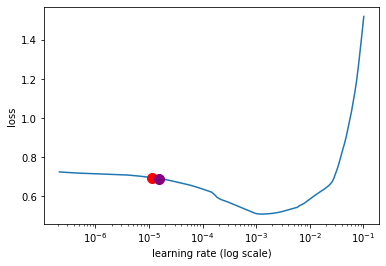

In [9]:
learner.lr_plot(suggest='true')

## Fine-tuning the model

In [10]:
learner.autofit(1.54e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 1.54e-05...
Epoch 1/1024
50/50 [==============================] - 64s 891ms/step - loss: 0.4784 - accuracy: 0.7588 - val_loss: 0.3424 - val_accuracy: 0.8662
Epoch 2/1024
50/50 [==============================] - 39s 786ms/step - loss: 0.1690 - accuracy: 0.9419 - val_loss: 0.3002 - val_accuracy: 0.8889
Epoch 3/1024
50/50 [==============================] - 40s 799ms/step - loss: 0.0898 - accuracy: 0.9716 - val_loss: 0.2941 - val_accuracy: 0.8965
Epoch 4/1024
50/50 [==============================] - 39s 790ms/step - loss: 0.0496 - accuracy: 0.9874 - val_loss: 0.2996 - val_accuracy: 0.9066
Epoch 5/1024
50/50 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9956
Epoch 00005: Reducing Max LR on Plateau: new max lr will be 7.7e-06 (if not early_stopping).
50/50 [==============================] - 40s

## Validation process

In [11]:
learner.validate(val_data = val)

13/13 [==============================] - 6s 111ms/step
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       216
           1       0.92      0.84      0.88       180

    accuracy                           0.90       396
   macro avg       0.90      0.89      0.89       396
weighted avg       0.90      0.90      0.90       396



array([[203,  13],
       [ 28, 152]])

In [12]:
predictor = ktrain.get_predictor(learner.model, t)

In [13]:
test_headlines = numpy.array(testing_set['encabezado'])
test_class = numpy.array(testing_set['clase'])

In [14]:
p = predictor.predict(test_headlines)

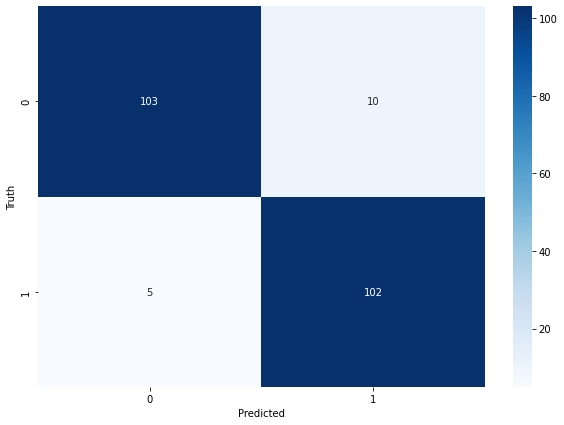

In [16]:
cm = confusion_matrix(p, test_class)
fig, ax = plt.subplots(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
plt.xlabel('Predicted')
plt.ylabel('Truth')
fig.savefig('cm.png')

In [17]:
from sklearn.metrics import classification_report
target_names = ['0', '1']
print(classification_report(test_class, p))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       108
           1       0.95      0.91      0.93       112

    accuracy                           0.93       220
   macro avg       0.93      0.93      0.93       220
weighted avg       0.93      0.93      0.93       220

